<font size = "5"> **Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />



# Z-Contrast Imaging


[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Imaging/CH3_09-Z_Contrast.ipynb)


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Imaging/CH3_09-Z_Contrast.ipynb)

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.

Note: This notebook needs a Linux environment and is most easily run in Colab

## Load important packages

In Colab the next code cell must be run first

### Check Installed Packages

In [5]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
    !pip install ase -q
    !pip install ipympl -q
    !pip install abtem -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2023.3.0':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
    if test_package('abtem') < '1.0.0b17':
        print('installing abtem')
        !{sys.executable} -m pip install  --upgrade abtem -q
# ------------------------------
print('done')

done


### Load Packages
We will use 
- numpy and matplotlib
- physical constants from scipy
- The pyTEMlib kinematic scattering librarty is only used to determine the wavelength.

abTEM

please cite abTEM methods article:

[J. Madsen & T. Susi, "The abTEM code: transmission electron microscopy from first principles", Open Research Europe 1: 24 (2021)](https://doi.org/10.12688/openreseurope.13015.1)


In [3]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
import sys
%matplotlib ipympl
if 'google.colab' in sys.modules:    
    from google.colab import output
    output.enable_custom_widget_manager()

import matplotlib.pyplot as plt
import numpy as np

# import atomic simulation environment
import ase
import ase.spacegroup
import ase.visualize

# import abintio-tem library
import abtem

__notebook__ = 'CH3_09-Z_Contrast'
__notebook_version__ = '2021_03_29'

ModuleNotFoundError: No module named 'abtem'

##  Z-contrast imaging
A Z-contrast image is acquired by scanning a ``convergent`` beam accross the sample and collecting signals with an ``annular`` (ring-like) detector. The detector sits in the convergent beam electron diffraction pattern plane and so it integrates over a ring-like part of the convergent beam diffraction (CBED) pattern.

More generally a scanning transmisison electron microscopy (STEM) image is still scanning the same  probe but integrates over different portions of the CBED pattern. A ``bright field detector`` for instance integrates over the inner part of the CBED pattern and is ``disk-like``.

## Make Structure and Potential with Frozen Phonons

As in the Dynamic Diffraction  with Frozen Phonons part in the [Thermal Diffuse Scattering notebook](CH3_08-Thermal_Diffuse_Scattering.ipynb), we first define the potential of the slices.

Again we use the ``abtem`` and ``ase`` packages to do this

### Defining the structure
Here we make a SrTiO$_3$ crystal again

Simulation cell: Cell([31.24, 31.24, 234.29999999999998])


<IPython.core.display.Javascript object>


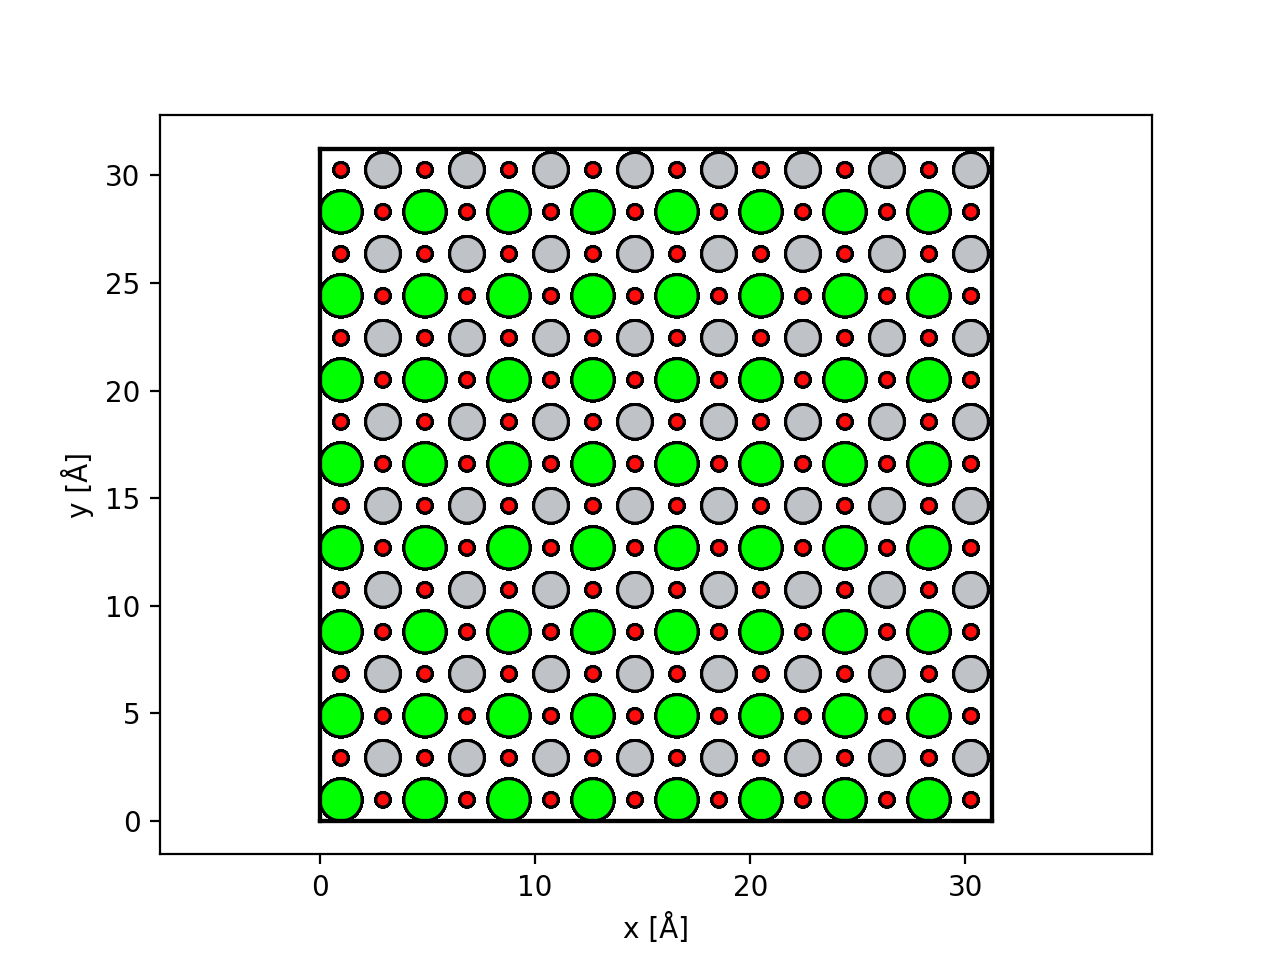

In [12]:
# ------- Input -----------#
thickness =30  # in nm
number_of_layers = 2  # per unit cell
# -------------------------#


atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = ase.spacegroup.crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(8, 8, 60))

srtio3.center()
print(f"Simulation cell: {srtio3.cell}")
abtem.show_atoms(srtio3);

### Make the potential 
with frozen phonon approximation

In [13]:
# ------ Input ------ #
number_of_frozen_phonon_runs = 12
# --------------------#

frozen_phonons = abtem.FrozenPhonons(srtio3, number_of_frozen_phonon_runs, {'Sr' : .1, 'Ti' : .1, 'O' : .1}, seed=1)
tds_potential = abtem.Potential(frozen_phonons, gpts=512, slice_thickness=3.905/2, 
                                projection='infinite', parametrization='kirkland')
print(f"Real space sampling: {tds_potential.sampling} Angstrom ")

Real space sampling: (0.061015625, 0.061015625) Angstrom 


### Make the probe 
The probe has to be on the same grid (matrix, pixels) as the potential, which is ensured with the ``grid.match`` function.

In [ ]:
# ---- Input ----- #
convergence_angle = 20  # in mrad of half angle
acceleration_voltage = 80e3 # in V
defocus = 40  # in nm
Cs = .5 # in mm            conversion to ase and Angstrom    *1-6 * 1e10 = 1e4
# -----------------#

probe = abtem.Probe(energy=acceleration_voltage, semiangle_cutoff=convergence_angle, 
                    rolloff=0.1, defocus=defocus, Cs=C_s*1e4, focal_spread=20)
probe.grid.match(tds_potential)

## Calculate CBED pattern 

As discussed before, in ``STEM`` we integrate over ``portions of the CBED pattern`` so we first calculate that. 

Because ``thermal diffuse scattering`` is so important we are using the thermal diffuse  potential in the ``frozen phonon approximation``.

Takes about 2 min on my laptop

TDS:   0%|          | 0/12 [00:00<?, ?it/s]

Multislice:   0%|          | 0/160 [00:00<?, ?it/s]

Potential:   0%|          | 0/160 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


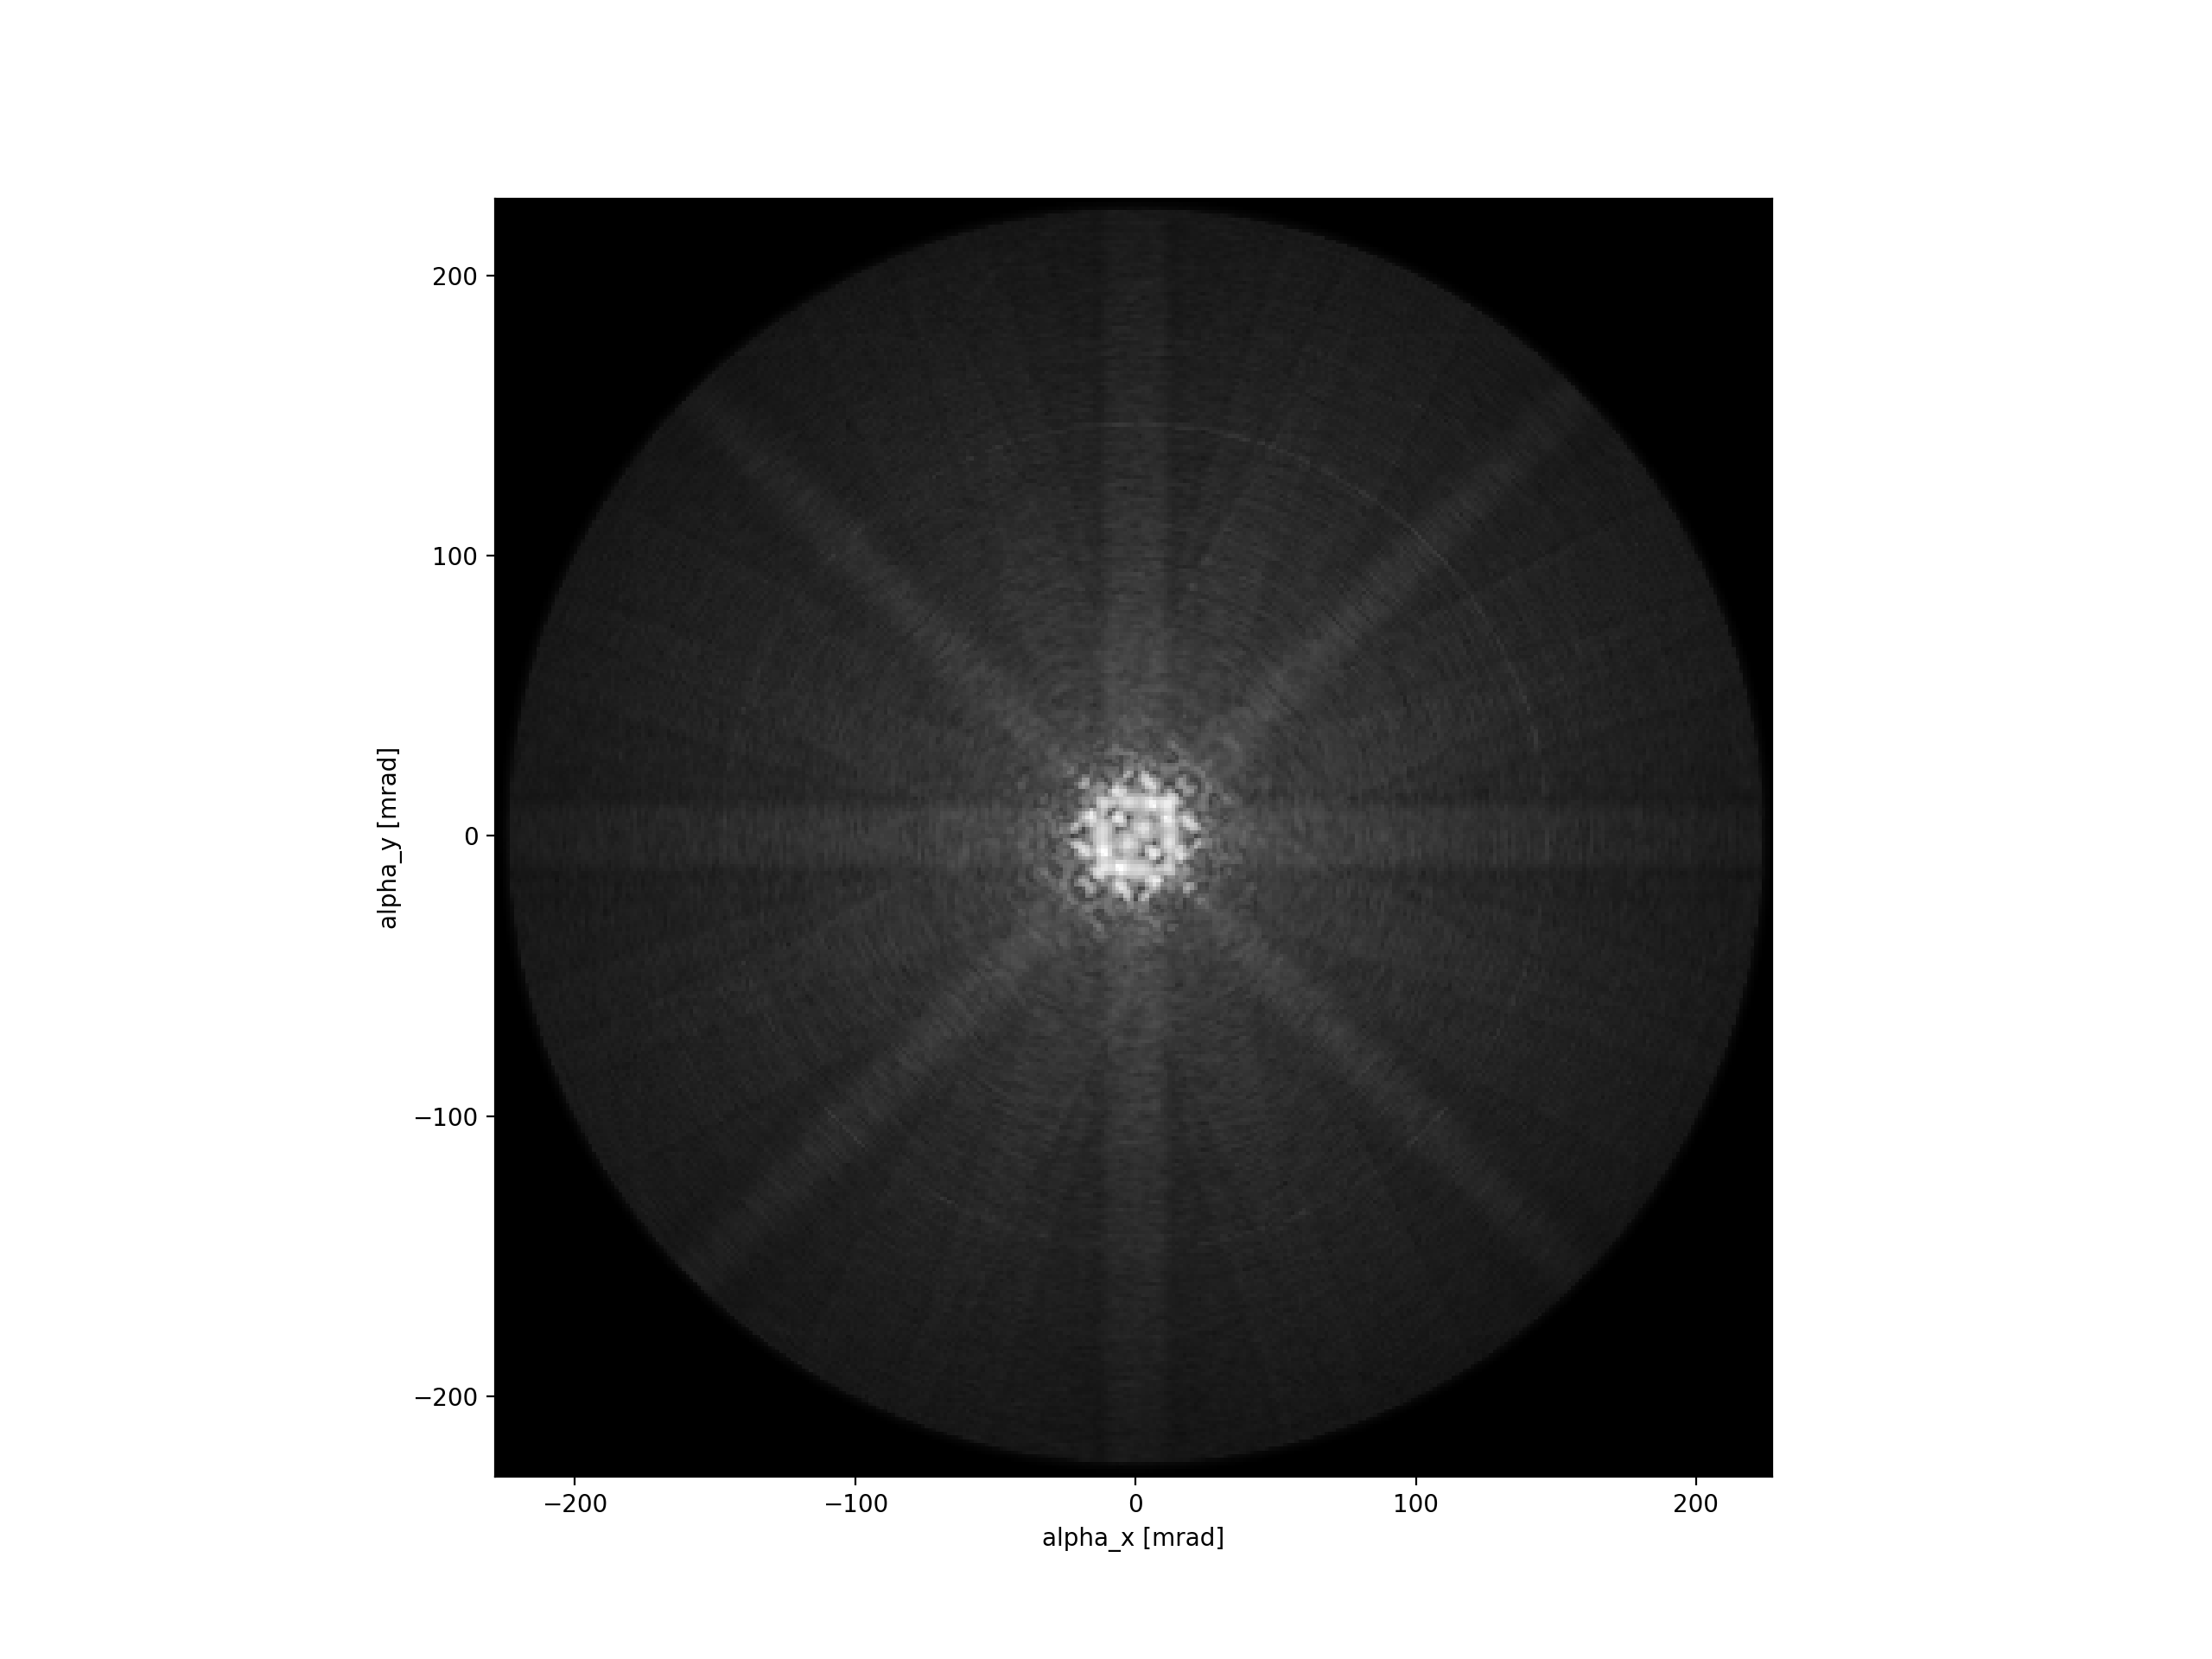

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x1e1cdc833a0>)

In [ ]:
detector = abtem.PixelatedDetector(max_angle='limit')
probe.grid.match(tds_potential)
tds_cbed = probe.build().multislice(tds_potential, pbar=True, detector=detector)
tds_cbed.mean(0).show(power=0.25)

## Detectors

The detectors are definded by their angles and ususally in mrad.

The detector are overlayed over the CBED pattern to indicate which part of the CBED is  integrated to get the intensity of one pixel.

Well, integration is may be a strong word for multiplying with a mask (1 where detector and 0  elsewhere) and sum over all pixels.


<IPython.core.display.Javascript object>


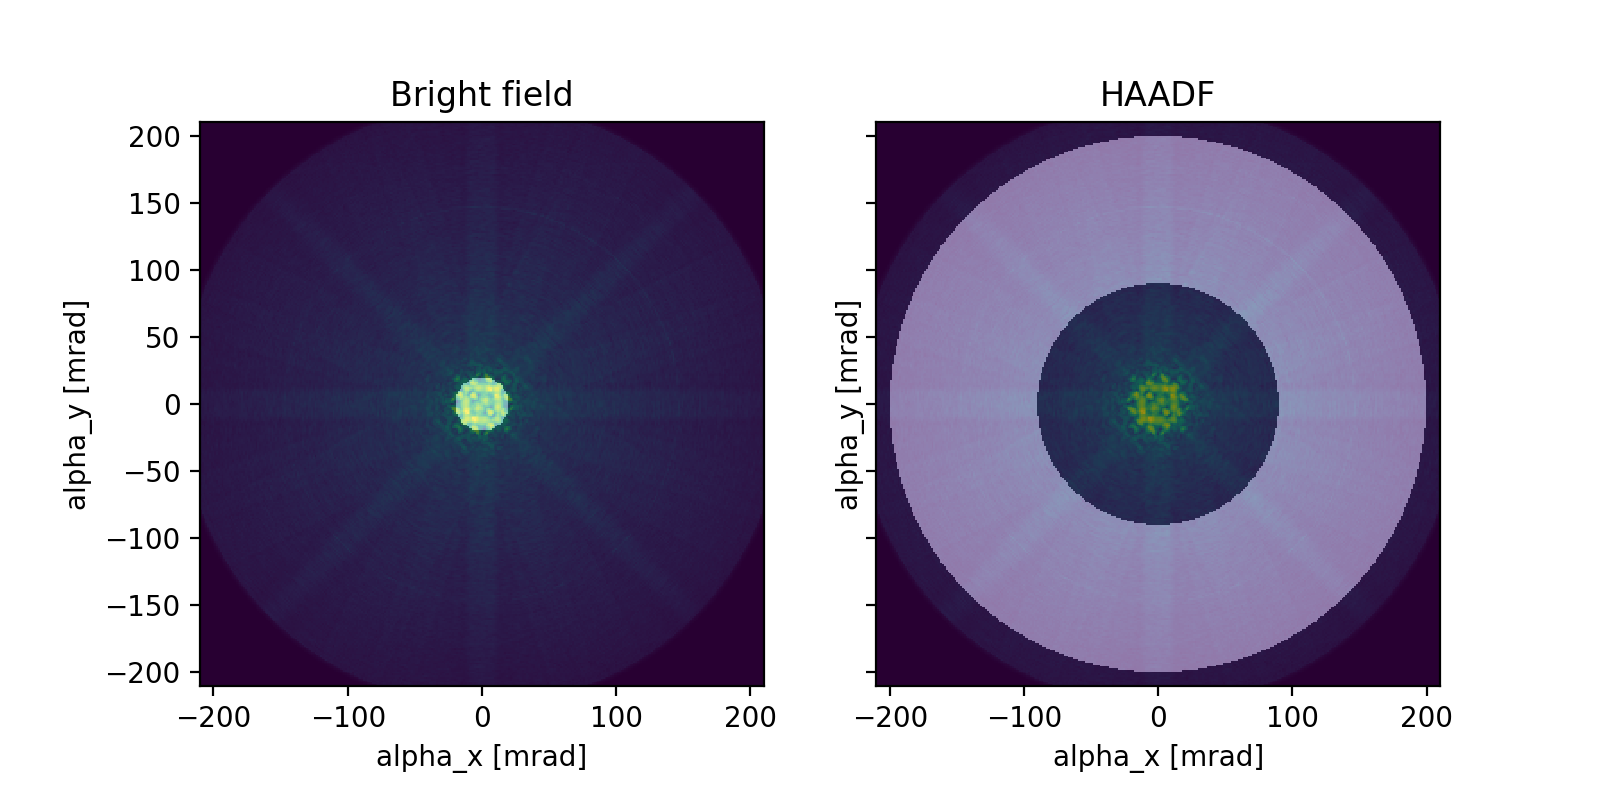

(-210.0, 210.0)

In [15]:
bright = abtem.AnnularDetector(inner=0, outer=20)
haadf = abtem.AnnularDetector(inner=90, outer=200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)

tds_cbed.mean(0).show(power=0.25, ax=ax1, cmap='viridis')
tds_cbed.mean(0).show(power=0.25, ax=ax2, cmap='viridis')
bright.show(probe, ax=ax1, title='Bright field', alpha=.4)
haadf.show(probe, ax=ax2, title='HAADF', alpha=.4);
ax1.set_xlim(-210,210)
ax1.set_ylim(-210,210)
ax2.set_xlim(-210,210)
ax2.set_ylim(-210,210)

We see that the HAADF detector is dominated by the features of thermal diffuse scattering.

While that part is not terribly important in the bright field image.

Please note:

 The detectors have to be well aligned on the optical axis or the simulation here is not valid.


## Scanning the Probe
### Get data directory



In [1]:
data_directory = './'

# if not in google.colab this will throw and error
from google.colab import drive
drive.mount('/content/drive')
!mkdir '/content/drive/My Drive/abtem'
data_directory = '/content/drive/My Drive/abtem/'

ModuleNotFoundError: No module named 'google'



### Define scanning area

<IPython.core.display.Javascript object>


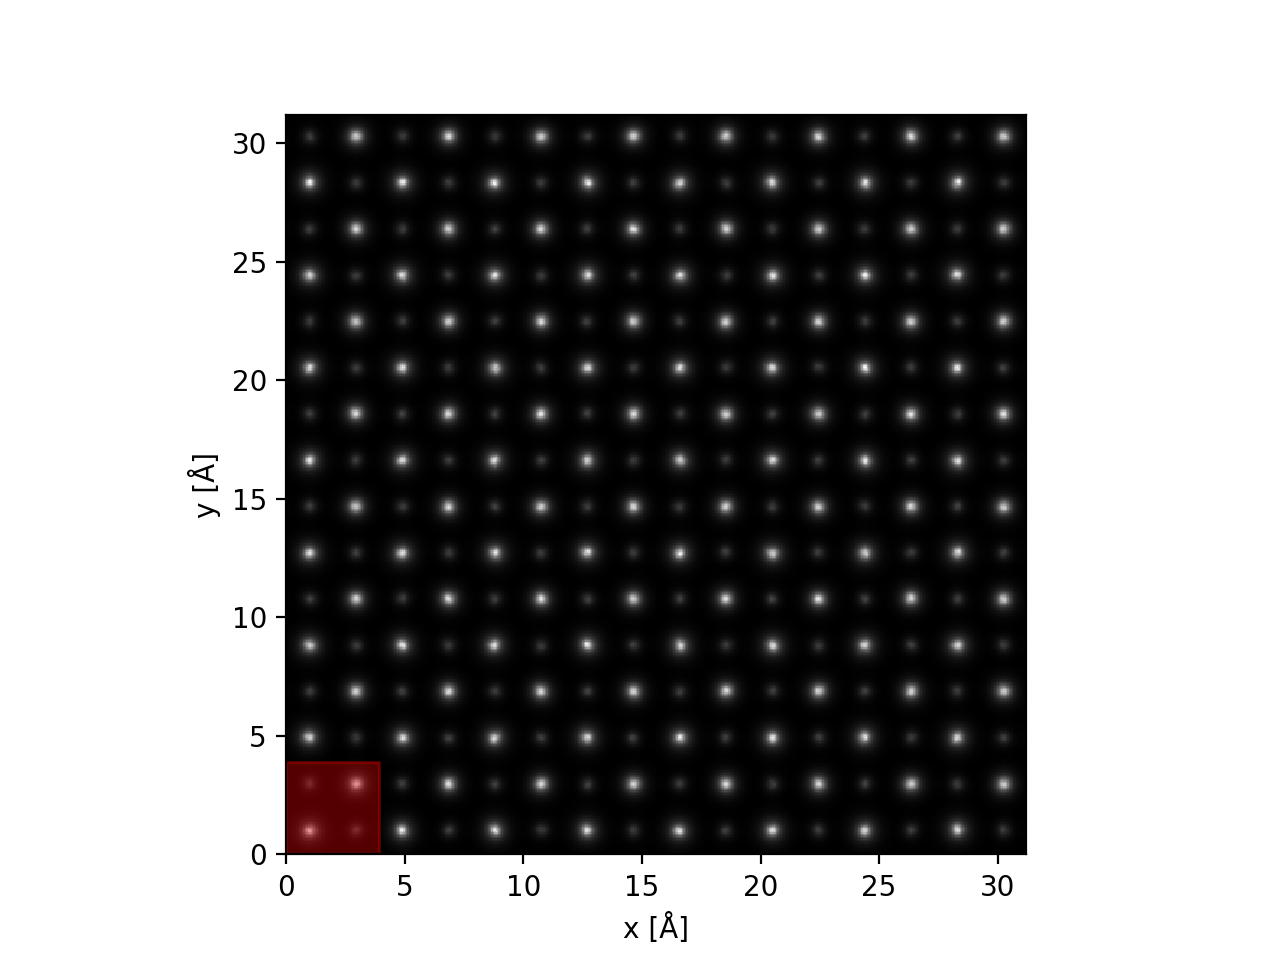

In [16]:
haadf_detector = abtem.AnnularDetector(inner=90, outer=190, save_file=data_directory+'gridscan_haadf.hdf5')
bf_detector  = abtem.AnnularDetector(inner=0, outer=20, save_file=data_directory+'gridscan_bf.hdf5')

gridscan = abtem.GridScan(start=[0, 0], end=[3.906, 3.906], sampling=probe.ctf.nyquist_sampling * .9)

ax, im = tds_potential.project().show();

gridscan.add_to_mpl_plot(ax)

### Now we are scanning

The results are going to be stored to file.

This takes about 20 min on my laptop

In [17]:
measurement_files = probe.scan(gridscan, [haadf_detector, bf_detector], tds_potential, pbar=True)

Scan:   0%|          | 0/81 [00:00<?, ?it/s]

TDS:   0%|          | 0/12 [00:00<?, ?it/s]

Potential:   0%|          | 0/120 [00:00<?, ?it/s]

### Checking output

['data/gridscan_haadf.hdf5', 'data/gridscan_bf.hdf5']


<IPython.core.display.Javascript object>


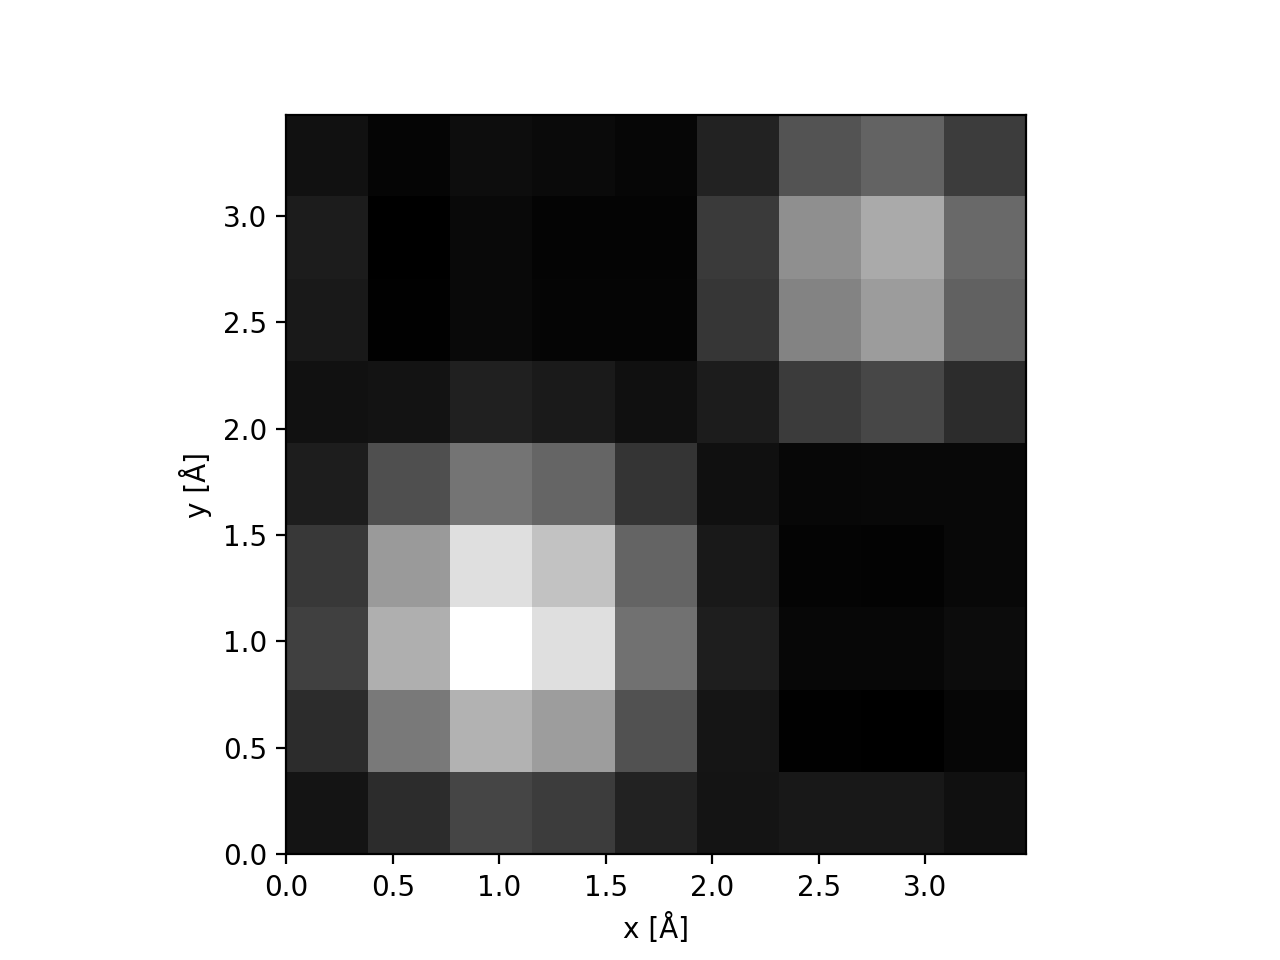

In [9]:
print(measurement_files)
measurement = abtem.Measurement.read(measurement_files[0])
measurement.show();

### Plotting result

<IPython.core.display.Javascript object>


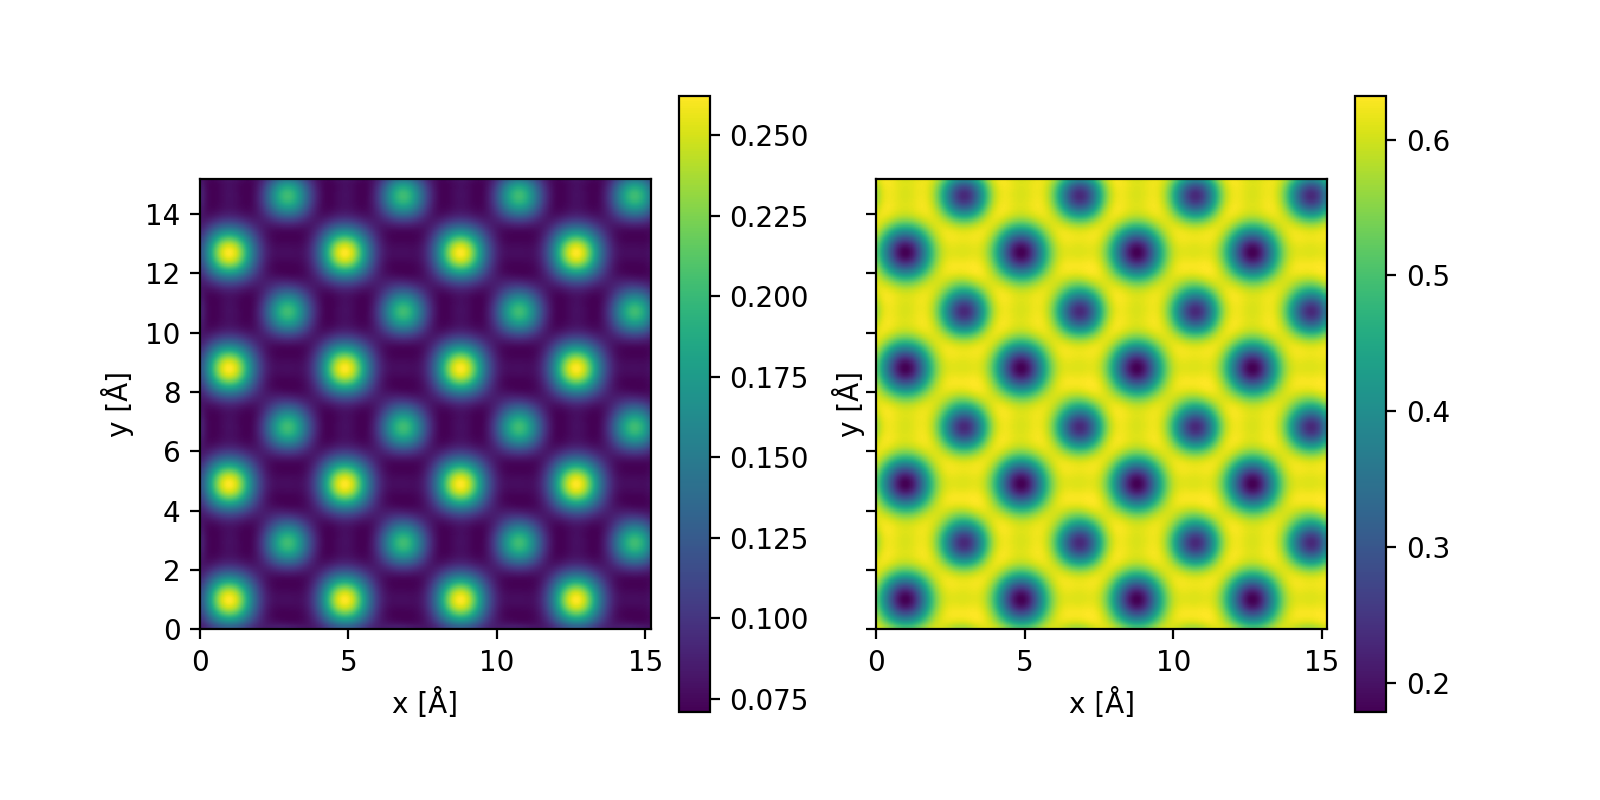

In [11]:
haadf_data = abtem.Measurement.read(measurement_files[0])
haadf_image = hadf_data.tile((4, 4))
haadf_image = haadf_image.interpolate(.04)

bf_data = abtem.Measurement.read(measurement_files[1])
bf_image = bf_data.tile((4, 4))
bf_image = bf_image.interpolate(.04)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)

_, im1= haadf_image.show(ax=ax1, cmap = 'viridis');
fig.colorbar(im1, ax=ax1, orientation='vertical')
_, im2 = bf_image.show(ax=ax2, cmap = 'viridis');
fig.colorbar(im2, ax=ax2, orientation='vertical')

## Experimental Consideration

- We need an as small a probe as possible. 
    - This will depend on the instrument especially everything before the sample!
    - This will depend on the defocus.
    - This will depend on the aperture, which will depend on the instrument and the largest coherent area.
    - This will depend on the aberrations and how well you corrected them
- We need to be tilted in the relevant zone axis
- We need a relatively thin specimen location




## Summary

For a quantitative image simulation we need to do dynamic scattering theory. 

The dynamic scattering theory is done within the multislice algorithm that treats each slice like a weak phase object.



 Thermal defuse scattering needs to be included into the multislice calculations for a good simulation


The thermal diffuse scattering can be approximated by the frozen phonon approximation but it is computationally intensive.